In [1]:
import numpy as np
import time
from dataset import ptb
import matplotlib.pyplot as plt

In [2]:
class Lstmlm:
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed = (rn(V, D) / 100).astype('f')
        lstmWx = rn(D, H*4) / np.sqrt(D)
        lstmWh = rn(H, H*4) / np.sqrt(H)
        lstmb = np.zeros((H*4), dtype='f')
        affineW = (rn(H, V) / np.sqrt(H)).astype('f')
        affineb = np.zeros(V).astype('f')
        
        self.params = [embed, lstmWx, lstmWh, lstmb, affineW, affineb]
        self.grads = []
        self.lstm = []
        
        self.wordvec_size = wordvec_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.time_idx = 0
    
    def forward(self, x, t):
        embed, lstmWx, lstmWh, lstmb, affineW, affineb = self.params
                
        batch_size, time_size = x.shape
        wordvec_size = self.wordvec_size
        hidden_size = self.hidden_size
        
        self.lstm = []
        
        h_prev = np.zeros((batch_size, hidden_size), dtype='f')
        c_prev = np.zeros((batch_size, hidden_size), dtype='f')
        hs = np.empty((batch_size, time_size, hidden_size), dtype='f')
        for t in range(time_size):
            # embed
            emb_out = embed[x[:, t]]
            
            # lstm
            A = np.matmul(emb_out, lstmWx) + np.matmul(h_prev, lstmWh) + lstmb
            f = A[:, :hidden_size]
            g = A[:, hidden_size: 2*hidden_size]
            i = A[:, 2*hidden_size: 3*hidden_size]
            o = A[:, 3*hidden_size:]

            f = self.sigmoid(f)
            g = np.tanh(g)
            i = self.sigmoid(i)
            o = self.sigmoid(o)

            c_next = f * c_prev + g * i
            h_next = o * np.tanh(c_next)
            
            hs[:, t, :] = h_next
            
            self.lstm.append((emb_out, h_prev, c_prev, f, g, i, o, c_next))
            c_prev = c_next
            h_prev = h_next
            
        
        # affine
        affine_out = np.matmul(hs, affineW) + affineb
        
        # softmax
        y = self.softmax(affine_out)
        
        loss = self.getLoss(y, batch_t)
        self.xs = x, hs, affine_out, y

        return y, loss
    
    def backward(self, t):
        embed, lstmWx, lstmWh, lstmb, affineW, affineb = self.params
        x, hs, affine_out, y = self.xs
        
        wordvec_size = self.wordvec_size
        vocab_size = self.vocab_size
        batch_size, time_size = x.shape
        
        # softmax
        y = y.reshape(batch_size * time_size, -1)
        t = t.reshape(batch_size * time_size)
        y[np.arange(batch_size * time_size), t] -= 1
        soft_dout = y
        
        # affine
        affine_dout = np.matmul(soft_dout, affineW.T).reshape(batch_size, time_size, -1) # (b, t, h)
        affinedW = np.matmul(hs.reshape(batch_size * time_size, -1).T, soft_dout) # (h, v)
        affinedb = np.sum(soft_dout, axis=0)
        
        # lstm
        lstmdWx = np.zeros_like(lstmWx)
        lstmdWh = np.zeros_like(lstmWh)
        lstmdb = np.zeros_like(lstmb)
        
        lstm_douts = np.empty((batch_size, time_size, wordvec_size), dtype='f')
        dh, dc = 0, 0
        for t in reversed(range(time_size)):            
            emb_out, h_prev, c_prev, f, g, i, o, c_next = self.lstm[t]
            dh_next = affine_dout[:, t, :] + dh
            dc_next = dc

            tanh_c_next = np.tanh(c_next)
            
            ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
            
            dc_prev = ds * f
            
            di = ds * g
            df = ds * c_prev
            do = dh_next * tanh_c_next
            dg = ds * i
            
            di *= i * (1 - i)
            df *= f * (1 - f)
            do *= o * (1 - o)
            dg *= (1 - g ** 2)
            
            dA = np.hstack((df, dg, di, do))
            
            dWh = np.matmul(h_prev.T, dA)
            dWx = np.matmul(emb_out.T, dA)
            db = np.sum(dA, axis=0)
            
            lstm_douts[:, t, :] = np.matmul(dA, lstmWx.T)
            dh_prev = np.matmul(dA, lstmWh.T)
        
            lstmdWx += dWx
            lstmdWh += dWh
            lstmdb += db
            dh = dh_prev
            dc = dc_prev
        
        # embed
        embed_dout = np.zeros_like(embed)
        for t in range(time_size):
            np.add.at(embed_dout, x[:, t], lstm_douts[:, t, :])
        
        self.grads = embed_dout, lstmdWx, lstmdWh, lstmdb, affinedW, affinedb
        
        
    def softmax(self, y):
        y = y - np.max(y)
        y = np.exp(y)
        y = y / y.sum(axis=2, keepdims=True)
        return y
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def update(self, lr):
        for i in range(len(self.params)):
            self.params[i] -= self.grads[i] * lr      
            
    def getLoss(self, y, t):
        N, T, V = y.shape

        y = y.reshape(N * T, V)
        t = t.reshape(N * T)

        ls = np.log(y[np.arange(N * T), t])
        return -np.sum(ls) / (N * T)
    
    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t
    
    def clip_grads(self, max_norm):
        grads = self.grads
        total_norm = 0
        
        for grad in grads:
            total_norm += np.sum(grad**2)
            
        total_norm = np.sqrt(total_norm)
        
        rate = max_norm / (total_norm + 1e-6)
        
        if rate  < 1:
            for grad in grads:
                grad *= rate
        self.grads = grads

In [3]:
# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # LSTM의 은닉 상태 벡터의 원소 수
time_size = 35  # LSTM을 펼치는 크기
lr = 20.0
max_epoch = 1
max_iters = len(xs) // (batch_size * time_size)
eval_interval = 20
max_grad = 0.25

In [4]:
model = Lstmlm(vocab_size, wordvec_size, hidden_size)

In [5]:
ppl_list = []
total_loss = 0
loss_count = 0
start_time = time.time()
model.time_idx = 0
for epoch in range(max_epoch):
    for iters in range(max_iters):
        batch_x, batch_t = model.get_batch(xs, ts, batch_size, time_size)

        y, loss = model.forward(batch_x, batch_t)
        model.backward(batch_t)
        model.clip_grads(max_grad)
        model.update(lr)
        
        total_loss += loss
        loss_count += 1

        if ((iters % eval_interval) == 0):
            ppl = np.exp(total_loss / loss_count)
            elapsed_time = time.time() - start_time
            print('| 에폭 %d | 반복 %d | 시간 %d[s] | loss %.2f | 퍼플렉서티 %.2f'
                % (epoch + 1, iters + 1, elapsed_time, loss, ppl))
            ppl_list.append(float(ppl))
            total_loss, loss_count = 0, 0

| 에폭 1 | 반복 1 | 시간 0[s] | loss 9.21 | 퍼플렉서티 9999.42
| 에폭 1 | 반복 21 | 시간 2[s] | loss 7.09 | 퍼플렉서티 2460.71
| 에폭 1 | 반복 41 | 시간 4[s] | loss 7.12 | 퍼플렉서티 1277.62
| 에폭 1 | 반복 61 | 시간 7[s] | loss 6.86 | 퍼플렉서티 910.46
| 에폭 1 | 반복 81 | 시간 9[s] | loss 6.34 | 퍼플렉서티 711.71
| 에폭 1 | 반복 101 | 시간 11[s] | loss 6.18 | 퍼플렉서티 585.24
| 에폭 1 | 반복 121 | 시간 14[s] | loss 6.28 | 퍼플렉서티 577.29
| 에폭 1 | 반복 141 | 시간 16[s] | loss 6.15 | 퍼플렉서티 530.14
| 에폭 1 | 반복 161 | 시간 19[s] | loss 6.11 | 퍼플렉서티 510.38
| 에폭 1 | 반복 181 | 시간 22[s] | loss 6.28 | 퍼플렉서티 518.21
| 에폭 1 | 반복 201 | 시간 24[s] | loss 5.98 | 퍼플렉서티 437.25
| 에폭 1 | 반복 221 | 시간 27[s] | loss 6.05 | 퍼플렉서티 425.42
| 에폭 1 | 반복 241 | 시간 29[s] | loss 5.93 | 퍼플렉서티 389.60
| 에폭 1 | 반복 261 | 시간 32[s] | loss 5.95 | 퍼플렉서티 400.14
| 에폭 1 | 반복 281 | 시간 35[s] | loss 5.68 | 퍼플렉서티 399.52
| 에폭 1 | 반복 301 | 시간 37[s] | loss 5.69 | 퍼플렉서티 347.36
| 에폭 1 | 반복 321 | 시간 40[s] | loss 5.29 | 퍼플렉서티 301.64
| 에폭 1 | 반복 341 | 시간 43[s] | loss 6.13 | 퍼플렉서티 358.54
| 에폭 1 | 반복 361 | 시간 46[s] | loss 5.

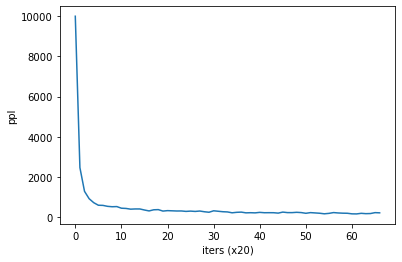

In [6]:
p = np.arange(len(ppl_list))
plt.plot(p, ppl_list, label='train')
plt.xlabel('iters (x' + str(eval_interval) + ')')
plt.ylabel('ppl')
plt.show()